In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load Network

터미널 상 현재 디렉토리에서 아래 코드를 실행하면 ```.prototxt```파일과 ```.caffemodel```파일을 볼 수 있다.
> cd pose/coo  
ls

```.prototxt```파일은 뉴럴 네트워크의 아키텍처를 정의하고,  
```.caffemodel```파일은 trained model의 weights들을 저장한다. 

이 두 파일을 사용해서, 메모리에 네트워크를 불러오자. 

In [2]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
    

참고로 ```nPoints```는 각 모델의 output 수를 의미한다. 

```COCO```와 ```MPI```는 둘 다 Body Pose Estimation을 위한 데이터셋이다.  
```COCO``` 데이터셋으로 학습한 모델의 경우 18개의 keypoints를,  
```MPI``` 데이터셋으로 학습한 모델의 경우 15개의 keypoints를 출력한다.

#### Let us load an image with multiple people and check what the model sees

현재 디렉토리 내에 ```nojunk.jpg``` 파일이 있을 것이다. 이 사진을 예시로 활용해보자.
<p align="center"><img src="nojunk.jpg" width="300"></p>

In [3]:
# Read the image
#image1 = cv2.imread("multiple.jpeg")
image1 = cv2.imread("nojunk.jpg")
print(image1.shape)

frameWidth = image1.shape[1]
frameHeight = image1.shape[0]
threshold = 0.1

(1152, 1600, 3)


#### Load the network and pass the image through the network

이미지를 OpenCV 포맷에서 Caffe blob 포맷으로 변환시켜야 한다.

이를 위해 [blobFromImage](https://docs.opencv.org/3.4/d6/d0f/group__dnn.html#ga29f34df9376379a603acd8df581ac8d7)함수를 사용할 수 있다.  
pixel들을 (0,1) 범위로 normalize시키고, 이미지 dimension 지정해주고, mean value인 (0,0,0)을 subtract해주자.

In [4]:
# Read the network into memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Specify the input image dimensions
inWidth = 368
inHeight = 368

# Prepare the frame to be fed into the network
inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

# Set the prepared object as the input blob of the network
net.setInput(inpBlob)

Forward pass를 위해 ```net.forward()```함수를 사용하자.

In [5]:
output = net.forward()
H = output.shape[2]
W = output.shape[3]
print(output.shape)

(1, 44, 46, 46)


### 4D matrix가 출력됨을 볼 수 있다.

첫번째 dimension ```1```은 이미지 ID를 나타낸다.

두번째 dimension ```44```은 keypoint 인덱스를 나타내는 부분이다. 
일전에 모델의 출력물이 Confidence Map과 Part Affinity Map라고 설명했었다. 실제로는 이것들이 모두 concatenated된 형태로 출력된다. 

우리가 예시로 보고자 하는 MPI모델의 경우 15(keypoints) + 1(background) + 14 * 2(pose pairs) = ```44```짜리 dimension을 갖는다.
참고로 COCO 모델의 경우, 18(keypoint) + 1(background) + 19 * 2(pose pairs) = ```57```짜리 dimension을 갖는다.

세번째 dimension ```46```은 Output map의 height를 나타낸다.
네번째 dimension ```46```은 Output map의 width를 나타낸다.

#### Slice a probability map from the output for a specific keypoint and plot the heatmap ( after resizing ) on the image itself

특정 keypoint에 대해 Confidence map을 그려보자. 
참고로 아래 코드에서는 여섯번째 keypoint인 left shoulder에 대한 Confidence map을 출력하고 있다.

In [6]:
i = 5
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))

OpenCV에서 color space 변환을 위해 ```cv2.cvtColor()```함수를 사용할 수 있다. OpenCV에서는 원래 BGR이기 때문에, 이를 RGB로 변환해주기 위해 ```cv2.COLOR_BGR2RGB```를 파라미터로 넣는다.

cf. BGR이기 때문에, 만약 변환하지 않은 상태로 ```plt.imshow(image1)```를 바로 시행하면 공포영화(?)스러운 비주얼을 볼 수 있다.

(-0.5, 1599.5, 1151.5, -0.5)

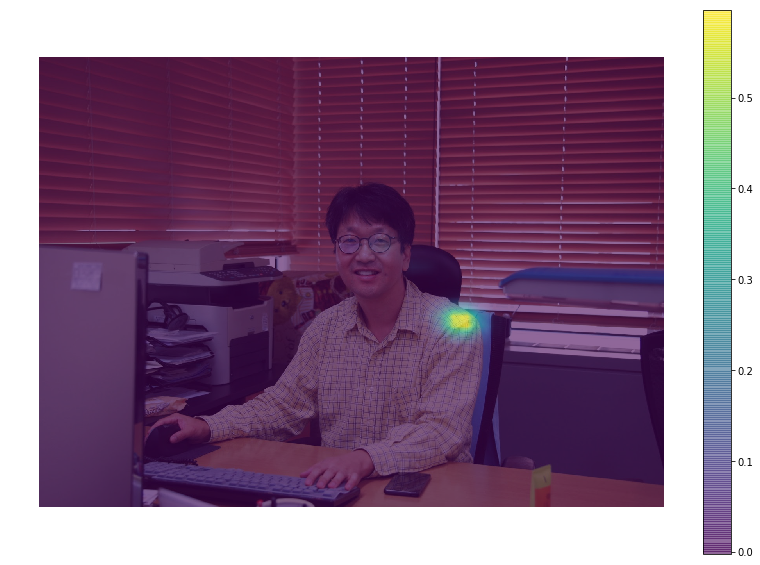

In [7]:
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

#### Similarly plot the affinity map on the image

같은 방식으로, 아래 코드에서는 Neck – Left Shoulder(Index: 24)에 대한 Part Affinity map을 출력하고 있다. (Index 부분이 헷갈리는 분들은 위에 4D matrix dimension 설명한 부분을 다시 참고하시길)

(-0.5, 1599.5, 1151.5, -0.5)

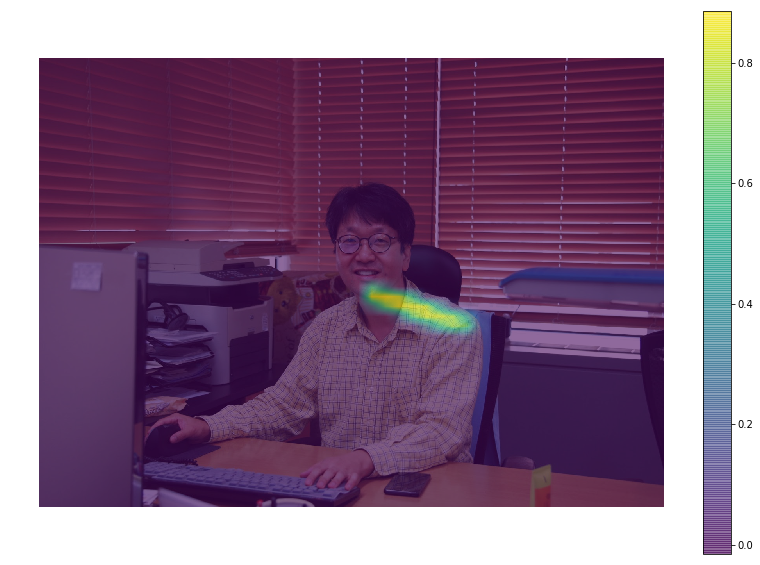

In [8]:
i = 24
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

#### Next, we find the keypoints for a image with only single person

현재 디렉토리 내에 ```single.jpeg``` 파일이 있을 것이다. 이 사진을 예시로 활용해보자.
<p align="center"><img src="single.jpeg" width="300"></p>

In [9]:
frame = cv2.imread("single.jpeg")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

#### Pass it through the network

In [10]:
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()
H = output.shape[2]
W = output.shape[3]

#### gather the points and plot the keypoints and the skeleton figure
위에서 출력한 Confidence map 상 global maxima를 찾아냄으로써 특정 keypoint의 location을 잡아낸다. 확률이 threshold이상인 지점만 찍어낼 수 있도록 한다.

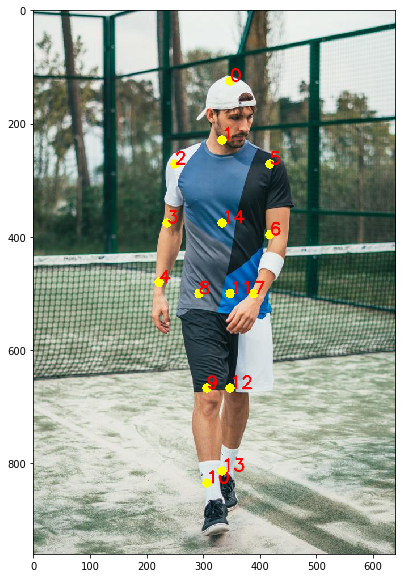

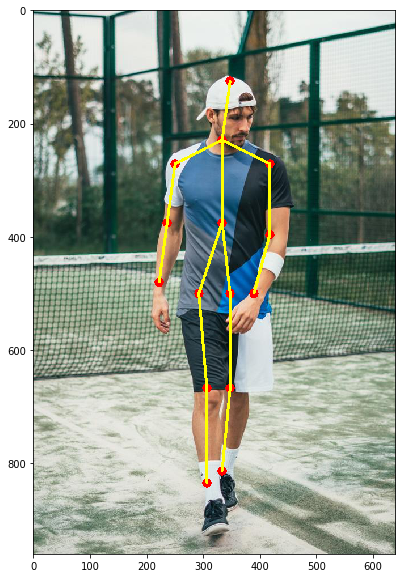

In [11]:
# Empty list to store the detected keypoints
points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)

plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))